In [1]:
AGENT_NAME = 'default_PPO_citylearn_challenge_2022_phase_2_Building_6_20_bins_500'
ADVERSARY_PATH = 'Models\Adversary\default_adversary_PPO_citylearn_challenge_2022_phase_2_Building_6_20_bins_default_rwd_480'
DATASET_NAME = 'citylearn_challenge_2022_phase_2' #only action is electrical storage

In [2]:
from stable_baselines3 import PPO

from citylearn.data import DataSet

from art.attacks.evasion import AutoConjugateGradient as ACG

import pandas as pd
import numpy as np
import os

import KBMproject.utilities as utils

%matplotlib inline

In [3]:
schema = DataSet.get_schema(DATASET_NAME)

Define RL agent

In [4]:
agent = PPO.load(path=f"{AGENT_NAME}")
print('Model loaded from storage')

Model loaded from storage


In [5]:
adv_path = os.path.join(os.getcwd(), '..',ADVERSARY_PATH) #get adversary from parent directory
adv_path = os.path.normpath(adv_path) #resolve '..'
adversary = PPO.load(path=adv_path)
print('Model loaded from storage')

Model loaded from storage


In [6]:
bins = agent.action_space[0].n
env = utils.make_discrete_env(schema=schema,  
                        action_bins=bins,
                        seed=42)

In [7]:
observation_masks = pd.Series(1, index=env.observation_names[0]).to_frame(name='all')
observation_masks['mask_time'] = observation_masks['all']
observation_masks['mask_time'][observation_masks.index.str.contains('month|day|hour')] = 0

In [9]:
init = 50
iter = int(500/init)
ACG_parameters = dict(
    loss_type='difference_logits_ratio', 
    batch_size=1,
    nb_random_init=init, #5, lower values speed crafting
    max_iter=iter, #iterations per restart
    norm='inf', #->l2 ->l1 most restrictive 
)
eps_list = [0.01, 0.03, 0.05, 0.07]
Adv_untargered_kpis, adv_untargeted_obs, adv_untargeted_eps = utils.eval_untargeted_dynamic_distortion_attack(agent,
                                                        env,
                                                        ART_atk=ACG,
                                                        ART_atk_kwargs=ACG_parameters,
                                                        eps_candidates=eps_list,
                                                        time_steps=10,
                                                        mask=observation_masks['mask_time'].to_numpy())
print(pd.Series(adv_untargeted_eps).value_counts())

100%|██████████| 10/10 [00:17<00:00,  1.76s/it]

The Adversarial success rate is: 1.0
The average distance between optinmal and adversarial actions is: 3.2
0.03    5
0.01    4
0.05    1
dtype: int64


In [10]:
target, _ = adversary.predict(env.reset(), deterministic=True)
from art.utils import to_categorical
print(target[0])
print(to_categorical(target, nb_classes=adversary.action_space[0].n))

19
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


This happens way too fast... can debug by setting breakpoints in the utilites file's dynamic distortion function. I have no idea why the sample generation is so fast, but it seems like none of the examples are successful

ACG is returning the smaple unchanged because the target is the same as the original action...I didn't think that would happen 10 time consecutively, but we need to pass in the actual action, and change it to categorical in the dynamic distortion function

I think I'll need a new dynamic distortion function , or a clause that checks if the action is the same as the target

In [27]:
init = 50
iter = int(500/init)
ACG_parameters = dict(
    loss_type='difference_logits_ratio', 
    batch_size=1,
    nb_random_init=init, #5, lower values speed crafting
    max_iter=100, #iterations per restart
    norm='inf', #->l2 ->l1 most restrictive
    targeted=True 
)
eps_list = [0.1,0.2, 0.3, 0.4, 0.5, 0.6]
Adv_targered_kpis, obs, adv_obs, adv_targeted_eps = utils.eval_targeted_dynamic_distortion_attack(agent,
                                                        adversary,
                                                        env,
                                                        ART_atk=ACG,
                                                        ART_atk_kwargs=ACG_parameters,
                                                        eps_candidates=eps_list,
                                                        time_steps=100,
                                                        mask=observation_masks['mask_time'].to_numpy())
display(Adv_targered_kpis)


100%|██████████| 100/100 [59:28<00:00, 35.68s/it] 

The Adversarial success rate is: 0.89
The average distance between optinmal and adversarial actions is: [1.06]


cost_function
annual_peak_average                       2.126763
carbon_emissions_total                    3.587793
cost_total                                3.385292
daily_one_minus_load_factor_average       1.133073
daily_peak_average                        3.134446
electricity_consumption_total             3.561327
monthly_one_minus_load_factor_average     1.034394
ramping_average                          14.874044
zero_net_energy                           1.627422
Name: District, dtype: float64

<Axes: ylabel='distortion size'>

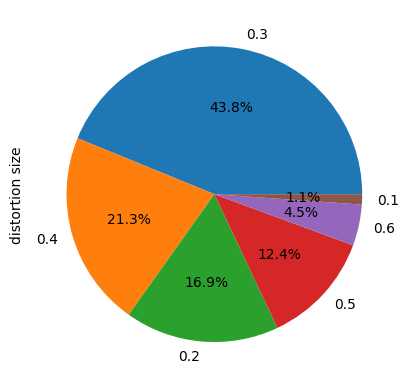

In [28]:
pd.Series(adv_targeted_eps).value_counts().plot.pie(ylabel='distortion size', autopct='%1.1f%%')

100%|█████████▉| 8758/8759 [55:44:49<00:22, 22.91s/it]    


The Adversarial success rate is: 0.28964493663660235
The average distance between optinmal and adversarial actions is: [11.12843932]


cost_function
annual_peak_average                      1.102260
carbon_emissions_total                   0.876466
cost_total                               0.795443
daily_one_minus_load_factor_average      1.045433
daily_peak_average                       0.912418
electricity_consumption_total            0.885576
monthly_one_minus_load_factor_average    0.990366
ramping_average                          1.122770
zero_net_energy                          1.108495
Name: District, dtype: float64

<Axes: ylabel='distortion size'>

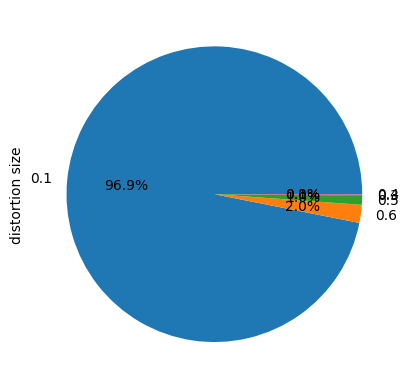

In [8]:
init = 50
iter = int(500/init)
ACG_parameters = dict(
    loss_type='difference_logits_ratio', 
    batch_size=1,
    nb_random_init=init, #5, lower values speed crafting
    max_iter=100, #iterations per restart
    norm='inf', #->l2 ->l1 most restrictive
    targeted=True 
)
eps_list = [0.1,0.2, 0.3, 0.4, 0.5, 0.6]
Adv_targered_kpis, obs, adv_obs, adv_targeted_eps = utils.eval_targeted_dynamic_distortion_attack(agent,
                                                        adversary,
                                                        env,
                                                        ART_atk=ACG,
                                                        ART_atk_kwargs=ACG_parameters,
                                                        eps_candidates=eps_list,
                                                        time_steps=None,
                                                        mask=observation_masks['mask_time'].to_numpy())
display(Adv_targered_kpis)
pd.Series(adv_targeted_eps).value_counts().plot.pie(ylabel='distortion size', autopct='%1.1f%%')

In [9]:
df_targeted_obs = pd.DataFrame(obs)
df_targeted_obs.to_csv('optimal attack observations.csv')
df_targeted_obs = pd.DataFrame(adv_obs)
df_targeted_obs.to_csv('optimal attack adversarial observations.csv')
df_targeted_obs = pd.DataFrame(adv_targeted_eps)
df_targeted_obs.to_csv('optimal attack eps.csv')

In [16]:
df_kpis = pd.read_csv('KPIs.csv', index_col='cost_function')
df_kpis

,baseline,random_noise,untargeted_adversarial_examples,untargeted_adv_v_threshold,Adv_v25_untargered_kpis,Adv_v75_untargered_kpis,df_v_ablation_kpis
cost_function,,,,,,,
annual_peak_average,1.102271,1.009338,1.198347,1.102271,1.102270,1.102271,1.068404
carbon_emissions_total,0.869186,0.870929,0.902045,0.891469,0.900611,0.880414,0.889796
cost_total,0.787803,0.786467,0.816997,0.805982,0.814078,0.799415,0.806549
daily_one_minus_load_factor_average,1.095762,1.091588,0.397182,1.002500,0.997434,0.365708,1.050107
daily_peak_average,0.894595,0.896781,0.961207,0.930231,0.945812,0.913327,0.939143
electricity_consumption_total,0.879108,0.881392,0.910717,0.901177,0.909467,0.890338,0.898543
monthly_one_minus_load_factor_average,0.988364,0.981307,0.992850,0.987415,0.991820,0.986949,0.993147
ramping_average,1.093749,1.105215,1.271853,1.196971,1.230539,1.151861,1.216366
zero_net_energy,1.107710,1.107912,1.108499,1.109079,1.108982,1.108470,1.108584


In [17]:
df_kpis['optimal_adv'] = Adv_targered_kpis.values

With an ASR of 28% the optimal adversarial attack fails to outperform and attack using untargeted adversarial perturbations. Not that the optimal attack has 10 times the adversarial budget in terms of iterations and distortion size. I expect the performance discrepancy is due to the vicitm's preference for certain actions, and this can be confirmed by comparing the logits for the optimal and optinal adversarial actions

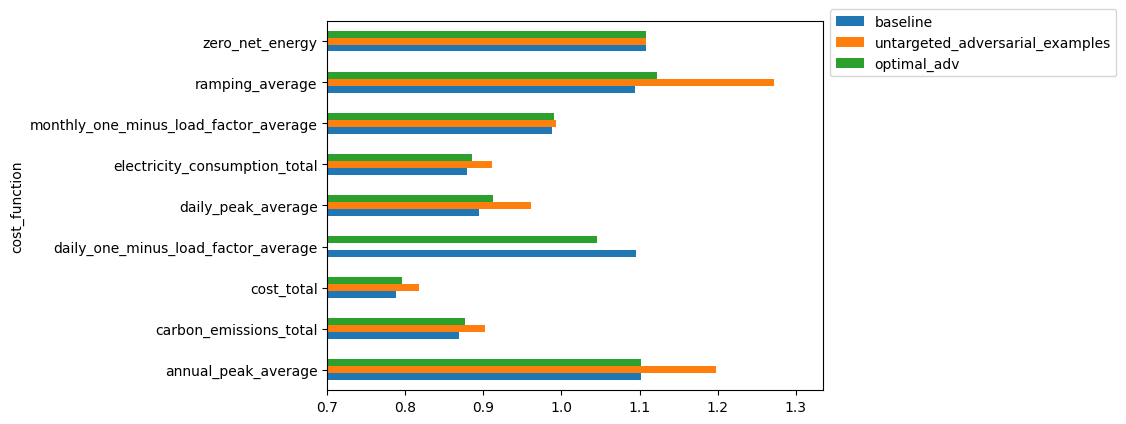

In [18]:
df_kpis[['baseline','untargeted_adversarial_examples','optimal_adv']].plot.barh(xlim=0.7).legend(bbox_to_anchor=(1.0, 1.05))

In [19]:
df_kpis.to_csv('KPIs.csv')